In [1]:
# from google.colab import drive
# drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraqm

In [2]:
# from IPython.display import clear_output
# !sudo apt-get install libfreetype6-dev libharfbuzz-dev libfribidi-dev gtk-doc-tools
# !git clone https://github.com/HOST-Oman/libraqm.git
# clear_output()

In [3]:
# cd libraqm/

/content/libraqm


In [4]:
# !sudo apt-get install autoconf libtool autogen
# !sudo /bin/bash autogen.sh 
# !sudo /bin/bash configure
# !sudo make
# !sudo make install
# !sudo make check
# !sudo /sbin/ldconfig
# clear_output()

In [5]:
# cd ..

/content


In [6]:
# !pip3 uninstall pillow -y
# !pip3 install pillow>=7.1.0 --global-option="build_ext" --global-option="--enable-freetype"
# clear_output()

## Make Sure These Two files are present

In [1]:
class_map_csv='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/class_map.csv'
font_path='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/Bangla.ttf'


## Error Check

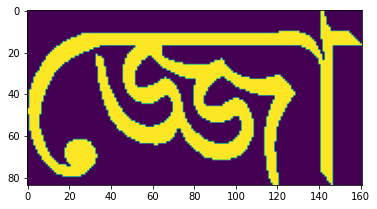

In [2]:
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import matplotlib.pyplot as plt
%matplotlib inline 
import os 
import cv2
import numpy as np


def stripPads(arr,val):
    '''
      strip specific values
    '''
    arr=arr[~np.all(arr == val, axis=1)]
    arr=arr[:, ~np.all(arr == val, axis=0)]
    return arr

def show_grapheme(char):
    HEIGHT = 256
    WIDTH = 256
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/Bangla.ttf', 128)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 2), char, font=myfont)
    image=image.convert('L')

    image=np.array(image)
    image[image <= 128]=0
    image[image > 128]=255

    image=stripPads(image,0)
    plt.imshow(image)
    plt.show()
    
show_grapheme("জ্জো")

## Parser Class

In [3]:
# -*-coding: utf-8 -
'''
    @author: Tahsin Reasat
    Adoptation:MD. Nazmuddoha Ansary
'''
#--------------------
# imports
#--------------------
import pandas as pd



#--------------------
# Parser class
#--------------------
class GraphemeParser():
    def __init__(self,class_map_csv):
        # gets class map
        self.class_map_csv=class_map_csv
        # initializes components
        self.__getComps()
    
    def __getComps(self):
        '''
            **Private Initialization**

            reads and creates dataframe for roots,consonant_diacritic,vowel_diacritic and graphemes 
            args:
                class_map_csv        : path of classes.csv
            returns:
                tuple(df_root,df_vd,df_cd)
                df_root          :     dataframe for grapheme roots
                df_vd            :     dataframe for vowel_diacritic 
                df_cd            :     dataframe for consonant_diacritic
                
        '''
        # read class map
        df_map=pd.read_csv(self.class_map_csv)
        # get grapheme roots
        df_root = df_map.groupby('component_type').get_group('grapheme_root')
        df_root.index = df_root['label']
        df_root = df_root.drop(columns = ['label','component_type'])
        # get vowel_diacritic
        df_vd = df_map.groupby('component_type').get_group('vowel_diacritic')
        df_vd.index = df_vd['label']
        df_vd = df_vd.drop(columns = ['label','component_type'])
        # get consonant_diacritic
        df_cd = df_map.groupby('component_type').get_group('consonant_diacritic')
        df_cd.index = df_cd['label']
        df_cd = df_cd.drop(columns = ['label','component_type'])
        
        self.vds    =df_vd.component.tolist()
        self.cds    =df_cd.component.tolist()
        self.roots  =df_root.component.tolist()

        

    def word2grapheme(self,word):
        graphemes = []
        grapheme = ''
        i = 0
        while i < len(word):
            grapheme += (word[i])
            # print(word[i], grapheme, graphemes)
            # deciding if the grapheme has ended
            if word[i] in ['\u200d', '্']:
                # these denote the grapheme is contnuing
                pass
            elif word[i] == 'ঁ':  
                # 'ঁ' always stays at the end
                graphemes.append(grapheme)
                grapheme = ''
            elif word[i] in list(self.roots) + ['়']:
                # root is generally followed by the diacritics
                # if there are trailing diacritics, don't end it
                if i + 1 == len(word):
                    graphemes.append(grapheme)
                elif word[i + 1] not in ['্', '\u200d', 'ঁ', '়'] + list(self.vds):
                    # if there are no trailing diacritics end it
                    graphemes.append(grapheme)
                    grapheme = ''

            elif word[i] in self.vds:
                # if the current character is a vowel diacritic
                # end it if there's no trailing 'ঁ' + diacritics
                # Note: vowel diacritics are always placed after consonants
                if i + 1 == len(word):
                    graphemes.append(grapheme)
                elif word[i + 1] not in ['ঁ'] + list(self.vds):
                    graphemes.append(grapheme)
                    grapheme = ''

            i = i + 1
            # Note: df_cd's are constructed by df_root + '্'
            # so, df_cd is not used in the code

        return graphemes

    

In [4]:
def createPrintedLine(iden,
                       comps,
                       font_path,
                       font_size):
    '''
        creates printed word image
        args:
            iden    :       identifier marking value starting
            comps   :       the list of components
            font_path:      the desired font path 
            font_size:      the size of the font
        returns:
            img     :       marked word image
            label   :       dictionary of label {iden:label}
            iden    :       the final identifier
    '''
    val_offset=iden
    comps=[str(comp) for comp in comps]
    # max dim
    min_offset=100
    max_dim=len(comps)*font_size+min_offset
    # reconfigure comps
    mods=['ঁ', 'ং', 'ঃ']
    for idx,comp in enumerate(comps):
        if idx < len(comps)-1 and comps[idx+1] in mods:
            comps[idx]+=comps[idx+1]
            comps[idx+1]=None 
            
    comps=[comp for comp in comps if comp is not None]
    word="".join(comps)
    # font path
    font=ImageFont.truetype(font_path, size=font_size)
    # sizes of comps
    (comp_size,_),(_,_) = font.font.getsize(word)  
    # construct labels
    label={}
    imgs=[]
    x=0
    y=0
    comp_str=''
    for comp in comps:
        comp_str+=comp
        # # calculate increment
        # (comp_width,_),(offset,_)=comp_size
        # dx = comp_width+offset 
        # draw
        image = Image.new(mode='L', size=(max_dim,max_dim))
        draw = ImageDraw.Draw(image)
        #draw.text(xy=(x, y), text=comp, fill=iden, font=font)
        draw.text(xy=(0, 0), text=comp_str, fill=1, font=font)
        
        imgs.append(np.array(image))
        
        # x+=dx
        # label
        if comp!=' ':
            label[iden] = comp 
            iden+=1
          
        
    # add images
    img=sum(imgs)
    #img=stripPads(img,0)
    img=img[~np.all(img == 0, axis=1)]
    img=img[:,:comp_size]
    img[img>0]+=val_offset-1
    return img,label,iden

In [5]:

def padImg(line_img,h_max,w_max):
    # shape
    h,w=line_img.shape
    # pad widths
    left_pad_width =(w_max-w)//2   # <<<<<<<<==========
    # print(left_pad_width)
    right_pad_width=w_max-w-left_pad_width   # <<<<<<<<==========
    # pads
    left_pad =np.zeros((h,left_pad_width))
    right_pad=np.zeros((h,right_pad_width))
    # pad
    line_img =np.concatenate([left_pad,line_img,right_pad],axis=1)
    
    # shape
    h,w=line_img.shape
    # pad heights
    top_pad_height =(h_max-h)//2
    bot_pad_height=h_max-h-top_pad_height
    # pads
    top_pad =np.zeros((top_pad_height,w))
    bot_pad=np.zeros((bot_pad_height,w))
    # pad
    line_img =np.concatenate([top_pad,line_img,bot_pad],axis=0)
    return line_img

In [6]:
# ------------------
from pprint import pprint
from PIL import Image
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import matplotlib.pyplot as plt
%matplotlib inline 
import os 
import cv2
import numpy as np
import regex
# ------------------

def memoHeadFunc(
                  head_names,
                  head_var_names,
                  class_map_csv_path,
                  font_path,
                  font_size=128,
                  bangla_num=["০","১","২","৩","৪","৫","৬","৭","৮","৯"],
                  iden=3

                 ):


    """
          @function author:

                Create image of top part of Memo

            args:
                head_names = text values of head part which are unchanged. like 
                              [
                              "এ.স. এন্টারপ্রাইজ",
                              "ড্রিস্ট্রিবিউটরঃ এম/এস হাশেম ট্রেডিং",
                              "হাউস নাম্বারঃ ১২৩৪, বাড্ডা, গুলশান, ঢাকা।",                                <LIST>
                              "মোবাইল নাম্বারঃ ০১৭২৩৪৫৬৭৮৯", 
                              "নাম্বারঃ",
                              "তারিখঃ"
                              ]  

              head_var_names = text values of head part which are included dot dot. like 
                                  [

                                  "আউটলেটের নামঃ",
                                  "রাউটঃ",                                                       <LIST>
                                  "ঠিকানাঃ"

                                    ]

              returns:
                    final_img            =  Binary Image after placing text on image.

    """


    gp=GraphemeParser(class_map_csv_path)

    ### Add space and dot with last two value of head_names list
    head_names[len(head_names)-1] = head_names[len(head_names)-1]+40*(".") ## Date
    head_names[len(head_names)-2] = head_names[len(head_names)-2]+40*(" ") # No.

    ## Add dot head_var_names list
    for i, p in enumerate(head_var_names):
        dot_len = 70-len(p)
        head_var_names[i] = head_var_names[i]+dot_len*(".")

    len_head_names = len(head_names)
    len_head_var_names = len(head_var_names)

    ## merge both list (head_names, head_var_names)
    data_Text = head_names + head_var_names

    ## Create Function: for Process the Text data
    def processText(dataText,
                    gp=gp,
                    bangla_num=bangla_num                   ########<<<<<<======== Func: processText()
                    ):
      
        data = []
        for i, p in enumerate(dataText):
            _data=[]
            rem_str=p
            # find pure bangla words and numbers
            words=regex.findall(r"[^\x20-\x2F\x3A-\x40\x5B-\x60\x7B-\x7E-\x7C]+",p)
            for idx,word in enumerate(words):

                comps=[]
                # find previous strings
                prev_str=rem_str.partition(word)[0]
                # get remainder string
                rem_str="".join(list(rem_str.partition(word)[2:]))

                if prev_str.strip():
                    comps+=[c for c in prev_str]
                # _data.append(word)   ### <<<<===
                if any(char in bangla_num for char in word):
                    comps+=[g for g in word]

                else:
                    comps+=gp.word2grapheme(word)

                # for last word
                if idx==len(words)-1:
                    comps+=[c for c in rem_str]

                comps.append(" ")
                _data+=comps

            # print(_data)  
            # print(len(_data))
            data.append(_data)

        return data

    data = processText(data_Text) ####<<<<<====== call Func: processText()

    imgs=[]
    labels=[]
    h_max,w_max=0,0
    # find images and labels
    i = 0
    for line in data: 
        i += 1
        if i==1:
            img,label,iden=createPrintedLine(iden,
                                        line,
                                        font_path,
                                        200)
        elif i==2:
            img,label,iden=createPrintedLine(iden,
                                        line,
                                        font_path,
                                        170)
        else:
            img,label,iden=createPrintedLine(iden,
                                        line,
                                        font_path,
                                        font_size)
        # print(iden)
        h,w=img.shape
        if h>h_max:
            h_max=h
        if w>w_max:
            w_max=w

        imgs.append(img)
        labels.append(label)

    h_max+=32
    w_max+=32

    padded=[]
    for img in imgs:
        img=padImg(img, h_max, w_max)
        padded.append(img)
        # plt.imshow(padImg(img, h_max, w_max))
        # plt.show()

    ## Merge Padded Images without last 2 values
    img_1=np.concatenate(padded[:len(head_names)-2],axis=0)
    (h_img_1, w_img_1) =  img_1.shape
    # plt.imshow(img_1)
    # plt.show() 

    ## merge last 2 values 
    img_2 = np.concatenate(padded[len(head_names)-2:len(head_names)], axis=1)
    (h_img_2, w_img_2) =  img_2.shape
    # plt.imshow(img_2)
    # plt.show() 

    ## Need reshape of img_2 to merge img_1 and img_2
    h= img_2.shape[0]
    w= img.shape[1]
    dim = (h, w)
    img_2_resized = cv2.resize(img_2, dim[::-1], interpolation = cv2.INTER_AREA)

    ## merge img_1 and img_2_resized
    img_3 = np.concatenate([img_1, img_2_resized], axis=0)
    # plt.imshow(img_3)
    # plt.show()

    ## Merge head_var_names
    im_4 = np.concatenate(padded[len(head_names):], axis=0)
    # plt.imshow(im_4)
    # plt.show()

    ## Merge img_3 and img_4: Final imgage
    final_img = np.concatenate([img_3, im_4], axis=0)
    # plt.imshow(final_img)
    # plt.show()

    # return
    return final_img

In [7]:
### Call Function: memoHeadFunc()

head_names=[
               "এ.স. এন্টারপ্রাইজ",
               "ড্রিস্ট্রিবিউটরঃ এম/এস হাশেম ট্রেডিং",
               "হাউস নাম্বারঃ ১২৩৪, বাড্ডা, গুলশান, ঢাকা।",    
               "মোবাইল নাম্বারঃ ০১৭২৩৪৫৬৭৮৯",
               "নাম্বারঃ",
               "তারিখঃ"
               ] 

head_var_names=[
                
               "আউটলেটের নামঃ",
               "রাউটঃ",
               "ঠিকানাঃ"
                
                ]

class_map_csv='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/class_map.csv'
font_path='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/Bangla.ttf'

final_image=memoHeadFunc(
                  head_names,
                  head_var_names,
                  class_map_csv_path=class_map_csv,
                  font_path=font_path)

### Clean View
final_image[final_image>0]=255
plt.imshow(final_image)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ApsisSolutions/demo_files/class_map.csv'

In [ ]:
### Call Function: memoHeadFunc()

head_names=[
               "ঢাকা সার্ভিস", 
               "এ.স. এন্টারপ্রাইজ",
               "ড্রিস্ট্রিবিউটরঃ এম/এস হাশেম ট্রেডিং",
               "হাউস নাম্বারঃ ১২৩৪, বাড্ডা, গুলশান, ঢাকা।",    
               "মোবাইল নাম্বারঃ ০১৭২৩৪৫৬৭৮৯",
               "নাম্বারঃ",
               "তারিখঃ"
               ] 

head_var_names=[
                
               "আউটলেটের নামঃ",
               "রাউটঃ",
               "ঠিকানাঃ",
                "জাতীয়তাঃ" 
                
                ]

class_map_csv='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/class_map.csv'
font_path='/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synthdata/__notes__/Bangla.ttf'

final_image=memoHeadFunc(
                  head_names,
                  head_var_names,
                  class_map_csv_path=class_map_csv,
                  font_path=font_path)

### Clean View
final_image[final_image>0]=255
plt.imshow(final_image)
plt.show()

### Clear View

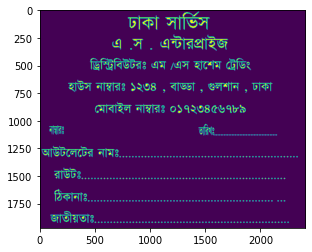

In [15]:
final_image[final_image>0]=255
plt.imshow(final_image)
plt.show()